In [1]:
import numpy as np
from scipy.optimize import curve_fit

import uproot

import seaborn as sns
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt

matplotlib.rcParams['font.serif'] = ['Computer Modern']

import zfit
import zfit.z.numpy  
from zfit import z 

#Two muon IDs >0.6
#gamme_E_cms>0.2 GeV
#gamma within CDC acceptance
#ap_theta > 0.175 rad and <2.9 rad
# chi2 > 0


#MC15-mumu:
#/pnfs/desy.de/belle/local/belle/MC/release-06-01-08/DB00002649/MC15rd_b/prod00027831/s00/e0026/4S/r01968/mumu/mdst/sub00/mdst_000001_prod00027831_task251967000001.root

#BKG CS: post on desy about mc luminosity

/home/sahil/anaconda3/lib/python3.10/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/home/sahil/anaconda3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
signame = ['Signal_0.4GeV(1).root',
           'Signal_0.6GeV(1).root',
           'Signal_0.8GeV(1).root',
           'Signal_1GeV(1).root',
           'Signal_2GeV(1).root',
           'Signal_4GeV(1).root',
           'Signal_6GeV(1).root',
           'Signal_8GeV(1).root',
           'Signal_9GeV(1).root'
          ]

sigmag = ['0.4 GeV', '0.6 GeV', '0.8 GeV', '1.0 GeV', '2.0 GeV', '4.0 GeV', '6.0 GeV', '8.0 GeV', '9.0 GeV']

datsig = [uproot.open(x) for x in signame]

filesig = [x['mumu'].arrays(library='np') for x in datsig]

mcname = ['Output_MC15_V2_mumu.root']

datmc = [uproot.open(x) for x in mcname]

filemc = [x['mumu'].arrays(library='np') for x in datmc]

file = filesig + filemc

print("0.4 GeV Signal:", len(file[0]['__experiment__']))
print("0.6 GeV Signal:", len(file[1]['__experiment__']))
print("0.8 GeV Signal:", len(file[2]['__experiment__']))
print("1.0 GeV Signal:", len(file[3]['__experiment__']))
print("2.0 GeV Signal:", len(file[4]['__experiment__']))
print("4.0 GeV Signal:", len(file[5]['__experiment__']))
print("6.0 GeV Signal:", len(file[6]['__experiment__']))
print("8.0 GeV Signal:", len(file[7]['__experiment__']))
print("9.0 GeV Signal:", len(file[8]['__experiment__']))
print("Background:", len(file[9]['__experiment__']))

0.4 GeV Signal: 2394
0.6 GeV Signal: 2203
0.8 GeV Signal: 1989
1.0 GeV Signal: 1999
2.0 GeV Signal: 2078
4.0 GeV Signal: 2448
6.0 GeV Signal: 2479
8.0 GeV Signal: 2528
9.0 GeV Signal: 2442
Background: 17558


In [4]:
def csfunc(eps, m):
    
    alpha = 1/137
    
    Ecom = 10.58
    thetamax = 12*np.pi/180
    thetamin = 155*np.pi/180
    
    Theta = np.log(((1+np.cos(thetamax))*(1-np.cos(thetamin)))/((1-np.cos(thetamax))*(1+np.cos(thetamin))))
    
    a = (2 * np.pi * alpha**2)/(Ecom**2) * eps**2
    
    b = 1 - m**2/Ecom**2
    
    c = 1 + (2 * m**2/Ecom**2)/b**2
    
    sigmagev = a * b * (c * Theta - np.cos(thetamax) + np.cos(thetamin))
                     
    sigmaSI = sigmagev * (0.197*1e-15)**2
    
    sigmafb = sigmaSI * (10**43)
    
    return sigmafb

/tmp/ipykernel_9859/1829846486.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


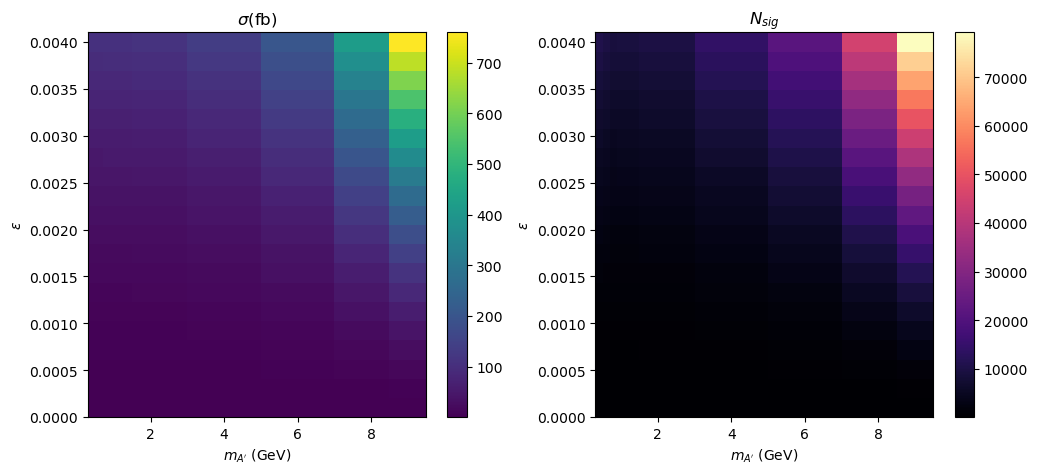

In [8]:
epsilon = np.linspace(1e-4, 4e-3, 30)
m = [0.4, 0.6, 0.8, 1, 2, 4, 6, 8, 9]
lumi = 427

sgm = np.zeros([len(epsilon),len(m)])

nsig = np.zeros([len(epsilon),len(m)])

for j in range(len(epsilon)):
    for i in range(len(m)):
        sgm[j][i] = csfunc(epsilon[j],m[i])
        nsig[j][i] = len(file[i]['__experiment__'])/10000 * lumi * sgm[j][i]
        
fig, ax = plt.subplots(1, 2, figsize = (12,5))
c1 = ax[0].pcolormesh(m, epsilon, sgm, cmap='viridis')
ax[0].set_xlabel(r"$m_{A'}$ (GeV)")
ax[0].set_ylabel(r"$\epsilon$")
ax[0].set_title(r"$\sigma$(fb)")
c2 = ax[1].pcolormesh(m, epsilon, nsig, cmap='magma')
ax[1].set_xlabel(r"$m_{A'}$ (GeV)")
ax[1].set_ylabel(r"$\epsilon$")
ax[1].set_title(r"$N_{sig}$")
fig.colorbar(c1, ax = ax[0])
fig.colorbar(c2, ax = ax[1])
fig.show()

In [6]:
#FUNCTION TO FIT BACKGROUND
def func(x, a):
    return np.exp(a*x)

#BACKGROUND FIT PARAMETER
bkglam = [[ None for i in range(len(m))] for j in range(len(epsilon))]

#FIT PARAMETERS
lam = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        namelam = 'lam' + '_' + str(i) + '_' + str(j)
        lam[i][j] = zfit.Parameter(namelam, 1)

exp_yield = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        nameexpyield = 'exp_yield' + '_'  + str(i) + '_'  + str(j)
        exp_yield[i][j] = zfit.Parameter(nameexpyield, 10000, step_size = 1)


sigma = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        sd = np.std(file[j]['ap_InvM'])
        namesigma = 'sigma' + '_'  + str(i) + '_'  + str(j)
        sigma[i][j] = zfit.Parameter(namesigma, sd)

alphal = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        namealphal = 'alpha_l' + '_'  + str(i) + '_'  + str(j)
        alphal[i][j] = zfit.Parameter(namealphal, 1)
        
nl = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        namenl = 'n_l' + '_' + str(i) + '_' + str(j)
        nl[i][j] = zfit.Parameter(namenl, 1)
        
alphar = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        namealphar = 'alpha_r' + '_' + str(i) + '_' + str(j)
        alphar[i][j] = zfit.Parameter(namealphar, 1)
        
nr = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        namenr = 'n_r' + '_' + str(i) + '_' + str(j)
        nr[i][j] = zfit.Parameter(namenr, 1)

dcb_yield = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        namedcbyield = 'dcb_yield' + '_' + str(i) + '_' + str(j)
        dcb_yield[i][j] = zfit.Parameter(namedcbyield, 200, step_size = 1)

mu = [[ None for i in range(len(m))] for j in range(len(epsilon))]
for i in range(len(epsilon)):
    for j in range(len(m)):
        namemu = 'mu' + '_' + str(i) + '_' + str(j)
        mu[i][j] = zfit.Parameter(namemu, m[j])
        
#CALCULATION PARAMETERS
        
dcb = [[ None for i in range(len(m))] for j in range(len(epsilon))]
nll = [[ None for i in range(len(m))] for j in range(len(epsilon))]

exp = [[ None for i in range(len(m))] for j in range(len(epsilon))]
nll1 = [[ None for i in range(len(m))] for j in range(len(epsilon))]

totalpdf = [[ None for i in range(len(m))] for j in range(len(epsilon))]
nllfinal = [[ None for i in range(len(m))] for j in range(len(epsilon))]
dcb_yield_poi = [[ None for i in range(len(m))] for j in range(len(epsilon))]
discovery = [[ None for i in range(len(m))] for j in range(len(epsilon))]

minimizer = [[ None for i in range(len(m))] for j in range(len(epsilon))]
minimizer1 = [[ None for i in range(len(m))] for j in range(len(epsilon))]
minimizer2 = [[ None for i in range(len(m))] for j in range(len(epsilon))]

minimum = [[ None for i in range(len(m))] for j in range(len(epsilon))]
minimum1 = [[ None for i in range(len(m))] for j in range(len(epsilon))]
check = [[ None for i in range(len(m))] for j in range(len(epsilon))]

calculator = [[ None for i in range(len(m))] for j in range(len(epsilon))]

#OUTPUT SIGNIFICANCE
final = [[ None for i in range(len(m))] for j in range(len(epsilon))]

In [9]:
#PRESELECTION SIGNAL, BACKGROUND AND DATA
sig = [[[] for i in range(len(m))] for j in range(len(epsilon))]
bkg = [[[] for i in range(len(m))] for j in range(len(epsilon))]

#SELECTED BACKGROUND
bkgselect = [[[] for i in range(len(m))] for j in range(len(epsilon))]

#FAKE DATA SET
finaldat = [[[] for i in range(len(m))] for j in range(len(epsilon))]

for i in range(len(epsilon)):
    for j in range(len(m)):
        
        #PRESELECTION OF SIGNAL, BACKGROUND AND FAKE DATA
        
        num = int(nsig[i][j]) #MINIMUM SIGNAL
        #numbkg = 42.7*len(file[9]['__experiment__']) 
        
        mean = np.mean(file[j]['ap_InvM'])
        
        range_ = (0.95*mean, 1.05*mean)
        
        bins_ = 30
        
        for k in range(num):
            choice = np.random.randint(0,len(file[j]['__experiment__']))
            if file[j]['ap_InvM'][choice]>range_[0] and file[j]['ap_InvM'][choice]<range_[1]:
                sig[i][j].append(file[j]['ap_InvM'][choice])
        for k in range(len(file[-1]['ap_InvM'])):
            if file[-1]['ap_InvM'][k]>range_[0] and file[-1]['ap_InvM'][k]<range_[1]:
                bkg[i][j].append(file[-1]['ap_InvM'][k])
        
        #FITTING BACKGROUND TO FILL GAPS

        bkgdot, bkgbin = np.histogram(bkg[i][j], bins = bins_, range = range_)
        bkgcenter = bkgbin[:-1] + np.diff(bkgbin)/2
        popt, pcov = curve_fit(func, bkgcenter, bkgdot)
        bkglam[i][j] = popt[0]

        #GENERATING BACKGROUND BASED ON THE FIT

        genrange = (0.80*(np.exp(bkglam[i][j]*mean)/bkglam[i][j]), 1.20*(np.exp(bkglam[i][j]*mean)/bkglam[i][j]))
        while len(bkgselect[i][j])<= int(len(bkg[i][j])*1125):
            y = np.random.uniform(genrange[0],genrange[1])
            k = (1/bkglam[i][j])*np.log(bkglam[i][j]*y)
            if k>range_[0] and k<range_[1]:
                bkgselect[i][j].append(k)
        
        print(i,j)
        finaldat[i][j] = sig[i][j]+bkgselect[i][j]

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8


In [10]:
for i in range(len(epsilon)):
    for j in range(len(m)):
        try:
            y = np.array(sig[i][j])

            range_ = (0.95*np.mean(y), 1.05*np.mean(y))

            obs = zfit.Space('x', limits=range_)
            data = zfit.data.Data.from_numpy(obs=obs, array=y)

            dcb[i][j] = zfit.pdf.DoubleCB(obs=obs, mu=mu[i][j], sigma=sigma[i][j], alphal = alphal[i][j], nl = nl[i][j], alphar = alphar[i][j], nr = nr[i][j])
            dcb[i][j].set_yield(dcb_yield[i][j])

            nll[i][j] = zfit.loss.ExtendedUnbinnedNLL(model=dcb[i][j], data=data) 

            minimizer[i][j] = zfit.minimize.Minuit()
            minimum[i][j] = minimizer[i][j].minimize(loss=nll[i][j])

            params = minimum[i][j].params

            ############################################

            y1 = np.array(bkgselect[i][j])

            obs = zfit.Space('x', limits=range_)
            data1 = zfit.data.Data.from_numpy(obs=obs, array=y1)

            exp[i][j] = zfit.pdf.Exponential(lam = lam[i][j], obs=obs)
            exp[i][j].set_yield(exp_yield[i][j])

            nll1[i][j] = zfit.loss.ExtendedUnbinnedNLL(model=exp[i][j], data=data1) 

            minimizer1[i][j] = zfit.minimize.Minuit()
            minimum1[i][j] = minimizer1[i][j].minimize(loss=nll1[i][j])

            params1 = minimum1[i][j].params

            ############################################

            totalpdf[i][j] = zfit.pdf.SumPDF([exp[i][j],dcb[i][j]])

            mu[i][j].floating = False
            sigma[i][j].floating = False
            alphal[i][j].floating = False
            nl[i][j].floating = False
            alphar[i][j].floating = False
            nr[i][j].floating = False
            lam[i][j].floating = False

            data2 = zfit.data.Data.from_numpy(obs=obs, array=np.array(finaldat[i][j]))

            nllfinal[i][j] = zfit.loss.ExtendedUnbinnedNLL(model = totalpdf[i][j], data = data2)

            minimizer2[i][j] = zfit.minimize.Minuit()
            check[i][j] = minimizer2[i][j].minimize(nllfinal[i][j])
            print(check[i][j])

            from hepstats.hypotests.calculators import AsymptoticCalculator
            from hepstats.hypotests.parameters import POI

            dcb_yield_poi[i][j] = POI(dcb_yield[i][j], 0)
            calculator[i][j] = AsymptoticCalculator(input = nllfinal[i][j], minimizer = minimizer2[i][j])
            
            
            
            from hepstats.hypotests import Discovery

            discovery[i][j] = Discovery(calculator = calculator[i][j], poinull = dcb_yield_poi[i][j])
        
        except Exception:
            continue

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, Composed_autoparam_2]] data=[<zfit.core.data.Data object at 0x7fbbe274a770>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═══════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm   │ min value   │
╞═════════╪═════════════╪══════════════════╪═══════╪═════════════╡
│ True    │ True        │ False            │ 1e-07 │ 1003.011    │
╘═════════╧═════════════╧══════════════════╧═══════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
exp_yield_0_0              124318       False
dcb_yield_0_0             104.395       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_4, Composed_autoparam_5]] data=[<zfit.core.data.Data object at 0x7fbbe251e950>] constraints=[]> 
with
<Minuit Minuit

│ True    │ True        │ False            │ 3.8e-06 │ 1002.7      │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
exp_yield_1_1              134351       False
dcb_yield_1_1             159.409       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_34, Composed_autoparam_35]] data=[<zfit.core.data.Data object at 0x7fbbde643ac0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═══════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm   │ min value   │
╞═════════╪═════════════╪══════════════════╪═══════╪═════════════╡
│ True    │ True        │ False            │ 1e-06 │ 1002.126    │
╘═════════╧═════════════╧══════════════════╧═══════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ---------------

│ True    │ True        │ False            │ 8e-05 │ 1000.058    │
╘═════════╧═════════════╧══════════════════╧═══════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
exp_yield_2_3             97944.6       False
dcb_yield_2_3             479.943       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_67, Composed_autoparam_68]] data=[<zfit.core.data.Data object at 0x7fbbdd870820>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 4.7e-06 │ 1001.035    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ---------

│ True    │ True        │ False            │ 1.2e-07 │ 1000.498    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
exp_yield_3_5              256496       False
dcb_yield_3_5             269.842       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_100, Composed_autoparam_101]] data=[<zfit.core.data.Data object at 0x7fbbddb00970>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 4.5e-08 │ 1000.394    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ---

│ True    │ True        │ False            │ 1.3e-06 │ -2478.316   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
exp_yield_5_8          2.9305e+06       False
dcb_yield_5_8             69398.2       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_163, Composed_autoparam_164]] data=[<zfit.core.data.Data object at 0x7fbbe24d5db0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.3e-05 │ 1003.091    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ---

│ True    │ True        │ False            │ 5.7e-05 │ 1001.114    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
exp_yield_8_2              131470       False
dcb_yield_8_2             1379.91       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_226, Composed_autoparam_227]] data=[<zfit.core.data.Data object at 0x7fbbe2b58520>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 4.5e-06 │ 1002.225    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ---

│ True    │ True        │ False            │ 4.9e-07 │ 1001.609    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
exp_yield_9_4              157442       False
dcb_yield_9_4             2310.63       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_259, Composed_autoparam_260]] data=[<zfit.core.data.Data object at 0x7fbbdc080580>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00045 │ 996.0792    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ---

│ True    │ True        │ False            │ 2.7e-07 │ 973.7807    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
--------------  ------------------  ----------
exp_yield_11_7         1.41384e+06       False
dcb_yield_11_7             19293.1       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_322, Composed_autoparam_323]] data=[<zfit.core.data.Data object at 0x7fbbdc3c6dd0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.3e-05 │ -4903.854   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
-------------

│ True    │ True        │ False            │ 1.2e-05 │ 1002.787    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
--------------  ------------------  ----------
exp_yield_14_1              134876       False
dcb_yield_14_1             5486.26       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_385, Composed_autoparam_386]] data=[<zfit.core.data.Data object at 0x7fbbdc3833d0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.3e-06 │ 1002.514    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
-------------

│ True    │ True        │ False            │ 9e-09 │ 1002.236    │
╘═════════╧═════════════╧══════════════════╧═══════╧═════════════╛

Parameters
name              value  (rounded)    at limit
--------------  ------------------  ----------
exp_yield_15_3             99026.6       False
dcb_yield_15_3             5626.38       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_418, Composed_autoparam_419]] data=[<zfit.core.data.Data object at 0x7fbbdc214520>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm    │ min value   │
╞═════════╪═════════════╪══════════════════╪════════╪═════════════╡
│ True    │ True        │ False            │ 0.0002 │ 989.2389    │
╘═════════╧═════════════╧══════════════════╧════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
--------------  ------

│ True    │ True        │ False            │ 2e-05 │ 981.3598    │
╘═════════╧═════════════╧══════════════════╧═══════╧═════════════╛

Parameters
name              value  (rounded)    at limit
--------------  ------------------  ----------
exp_yield_17_7          1.4136e+06       False
dcb_yield_17_7             39500.6       False
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_484, Composed_autoparam_485]] data=[<zfit.core.data.Data object at 0x7fbbdb84c2e0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00055 │ -2935.425   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)    at limit
--------------  -

In [27]:
final = [[ None for i in range(len(m))] for j in range(len(epsilon))]

for i in range(len(epsilon)):
    for j in range(len(m)):
        try:
            k = discovery[i][j].result()[1]
            if discovery[i][j] != None:
                if k != float('inf'):
                    print(i,' ', j, ':')
                    final[i][j] = discovery[i][j].result()[1]
                else:
                    print(i,' ', j, ':')
                    final[i][j] = 10
            else:
                print(i,' ', j, ':')
                final[i][j] = 0
        except Exception:
            print(i,' ', j, ':')
            final[i][j] = 0
            continue

for i in range(len(epsilon)-1):
    for j in range(len(m)):
        if final[i+1][j] == 10 and final[i-1][j] == 10:
            final[i][j] = 10


p_value for the Null hypothesis = 0.24226405598744893
Significance (in units of sigma) = 0.6990382740686331
0   0 :

p_value for the Null hypothesis = 0.24226405598744893
Significance (in units of sigma) = 0.6990382740686331

p_value for the Null hypothesis = 1.1312474358260438e-05
Significance (in units of sigma) = 4.237274476681828
0   1 :

p_value for the Null hypothesis = 1.1312474358260438e-05
Significance (in units of sigma) = 4.237274476681828

p_value for the Null hypothesis = 0.23081632732816026
Significance (in units of sigma) = 0.7361611130280968
0   2 :

p_value for the Null hypothesis = 0.23081632732816026
Significance (in units of sigma) = 0.7361611130280968

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
0   3 :

p_value for the Null hypothesis = 0.42252995383525915
Significance (in units of sigma) = 0.19542543314617047
0   4 :

p_value for the Null hypothesis = 0.42252995383525915
Significance (in units of sigma) = 0.19542543314617047

p_v

Significance (in units of sigma) = inf
11   8 :

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
12   0 :

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
12   1 :

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
12   2 :

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
12   3 :

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
12   4 :

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
12   5 :

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
12   6 :

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
12   7 :

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
12   8 :

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
13   0 :

p_value for the Null hypothesis = 0.0
Significance (in units of sigma) = inf
13  

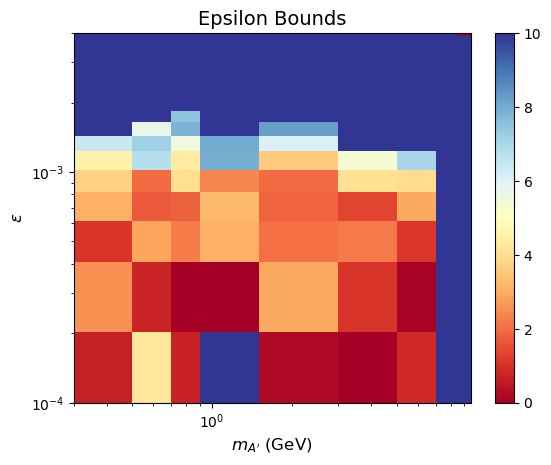

In [28]:
x, y = np.meshgrid(m, epsilon)

plt.tick_params(axis='x', which='minor')
plt.pcolormesh(x, y, final, cmap='RdYlBu')
plt.xlabel(r"$m_{A'}$ (GeV)",fontsize = 12)
plt.xscale('log')
plt.ylabel(r"$\epsilon$", fontsize = 12)
plt.yscale('log')
plt.ylim(epsilon[0],epsilon[-1])
plt.title("Epsilon Bounds", fontsize = 14)
plt.colorbar()
plt.show()

In [29]:
lims = []
nums = []
k = np.zeros(len(m))

for j in range(len(m)):
    for i in range(len(epsilon)-2,0,-2):
        if final[i][j]<5:
            lims.append(epsilon[i+1])
            k[j] = 1
            nums.append(i+1)
            break
    if k[j]==0:
        lims.append(epsilon[0])
        nums.append(0)

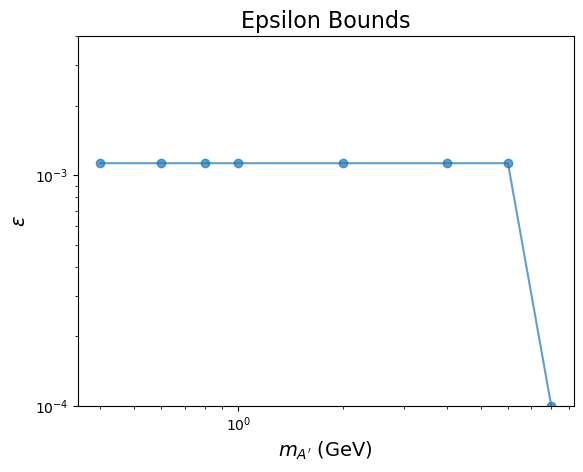

In [30]:
plt.plot(m[0:-1], lims[0:-1], 'o-',  alpha = 0.7)
plt.xlabel(r"$m_{A'}$ (GeV)", fontsize = 14)
plt.xscale('log')
plt.ylabel(r"$\epsilon$", fontsize = 14)
plt.yscale('log')
plt.ylim(1e-4,4e-3)
plt.title("Epsilon Bounds", fontsize = 16)
plt.show()

In [31]:
print(lims)

[0.0011263157894736843, 0.0011263157894736843, 0.0011263157894736843, 0.0011263157894736843, 0.0011263157894736843, 0.0011263157894736843, 0.0011263157894736843, 0.0001, 0.0001]


Text(0.5, 0, "$m_{A'}$ (GeV)")

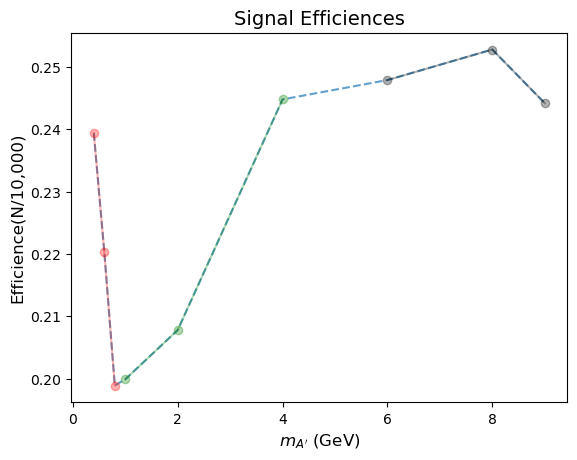

In [32]:
efficiencies = []

for i in range(len(m)):
    efficiencies.append(len(file[i]['__experiment__'])/10000)

plt.plot(m, efficiencies,  '--', alpha = 0.7)
plt.plot(m[0:3], efficiencies[0:3], 'o-', alpha = 0.3, color = 'red')
plt.plot(m[3:6], efficiencies[3:6], 'o-', alpha = 0.3, color = 'green')
plt.plot(m[6:], efficiencies[6:], 'o-', alpha = 0.3, color = 'black')

plt.title('Signal Efficiences', fontsize = 14)
plt.ylabel('Efficience(N/10,000)', fontsize = 12)
plt.xlabel(r"$m_{A'}$ (GeV)", fontsize = 12)

In [ ]:
from hepstats.hypotests.parameters import POI, POIarray
from hepstats.hypotests import UpperLimit

obslim = [[ None for i in range(len(m))] for j in range(len(epsilon))]
explim = [[ None for i in range(len(m))] for j in range(len(epsilon))]
explims1pos = [[ None for i in range(len(m))] for j in range(len(epsilon))]
explims1neg = [[ None for i in range(len(m))] for j in range(len(epsilon))]
explims2pos = [[ None for i in range(len(m))] for j in range(len(epsilon))]
explims2neg = [[ None for i in range(len(m))] for j in range(len(epsilon))]

poialt = [[ None for i in range(len(m))] for j in range(len(epsilon))]
poinull = [[ None for i in range(len(m))] for j in range(len(epsilon))]

i = 5

for j in range(len(m)):
    
    try:
        poialt[i][j] = POI(dcb_yield[i][j], 0)
        poinull[i][j] = POIarray(dcb_yield[i][j], np.linspace(0.0, 5000, 100))

        ul = UpperLimit(calculator[i][j], poinull[i][j], poialt[i][j])

        rez = ul.upperlimit(alpha=0.05, CLs=True)

        obslim[i][j] = rez['observed']
        explim[i][j] = rez['expected']
        explims1pos[i][j] = rez['expected_p1']
        explims1neg[i][j] = rez['expected_m1']
        explims2pos[i][j] = rez['expected_p2']
        explims2neg[i][j] = rez['expected_m2']
        
    except Exception:
        obslim[i][j] = 0
        explim[i][j] = 0
        explims1pos[i][j] = 0
        explims1neg[i][j] = 0
        explims2pos[i][j] = 0
        explims2neg[i][j] = 0
        continue



Get fitted values of the nuisance parameters for the alternative hypothesis!
FitResult of
<ExtendedBinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7fbbdb8afc40>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7fbbe22b8430>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm    │ min value   │
╞═════════╪═════════════╪══════════════════╪════════╪═════════════╡
│ True    │ True        │ False            │ 0.0002 │ 520.6485    │
╘═════════╧═════════════╧══════════════════╧════════╧═════════════╛

Parameters
name             value  (rounded)    at limit
-------------  ------------------  ----------
exp_yield_5_0              125518       False

Observed upper limit: dcb_yield_5_0 = 1285.9127199360328
Expected upper limit: dcb_yield_5_0 = 403.2843673419763
Expected upper limit +1 sigma: dcb_yield_5_0 = 561.8963436612518
Expected upper limit -1 s

In [ ]:
k = 5

fig, ax = plt.subplots(1, 1)

ax.plot(m[:-1], explim[k][:-1], c = 'r', label = 'Expected')
ax.plot(m[:-1], obslim[k][:-1], 'o--', label = 'Observed')
ax.fill_between(m[:-1], explims1pos[k][:-1], explims1neg[k][:-1], alpha = 0.1, label = 'Expected (1$\sigma$)')
ax.fill_between(m[:-1], explims2pos[k][:-1], explims2neg[k][:-1], alpha = 0.1, label = 'Expected (2$\sigma$)')
ax.set_title('Signal Yield Upper Limits')
    
fig.show()

In [ ]:
def nsigtoepsilon(nsignal, mass, eff):
    
    lumi = 427
    
    cs = nsignal/(lumi*eff)
    
    alpha = 1/137
    
    Ecom = 10.58
    thetamax = 12*np.pi/180
    thetamin = 155*np.pi/180
    
    cssi = cs/(10**43)
    csgev = cssi/((0.197*1e-15)**2)
    
    b = 1 - mass**2/Ecom**2
    
    c = 1 + (2 * mass**2/Ecom**2)/b**2
    
    Theta = np.log(((1+np.cos(thetamax))*(1-np.cos(thetamin)))/((1-np.cos(thetamax))*(1+np.cos(thetamin))))
    
    a = csgev/(b * (c * Theta - np.cos(thetamax) + np.cos(thetamin)))
    
    epssquared = a/((2 * np.pi * alpha**2)/(Ecom**2))
    
    eps = np.sqrt(epssquared) 
      
    return eps

In [ ]:
k = 5 

epsilonexplim = []
epsilonobslim = []
epsilonexplims1pos = []
epsilonexplims1neg = []
epsilonexplims2pos = []
epsilonexplims2neg = []

for j in range(len(explim[k])):
    epsilonexplim.append(nsigtoepsilon(explim[k][j], m[j], efficiencies[j]))
    epsilonobslim.append(nsigtoepsilon(obslim[k][j], m[j], efficiencies[j]))
    epsilonexplims1pos.append(nsigtoepsilon(explims1pos[k][j], m[j], efficiencies[j]))
    epsilonexplims1neg.append(nsigtoepsilon(explims1neg[k][j], m[j], efficiencies[j]))
    epsilonexplims2pos.append(nsigtoepsilon(explims2pos[k][j], m[j], efficiencies[j]))
    epsilonexplims2neg.append(nsigtoepsilon(explims2neg[k][j], m[j], efficiencies[j]))

In [ ]:
k = i

fig, ax = plt.subplots(1, 1)

ax.plot(m[:-1], epsilonexplim[:-1], c = 'r', label = 'Expected')
ax.plot(m[:-1], epsilonobslim[:-1], 'o--', label = 'Observed')
ax.fill_between(m[:-1], epsilonexplims1pos[:-1], epsilonexplims1neg[:-1], alpha = 0.1, label = 'Expected (1$\sigma$)')
ax.fill_between(m[:-1], epsilonexplims2pos[:-1], epsilonexplims2neg[:-1], alpha = 0.1, label = 'Expected (2$\sigma$)')
ax.set_title('Signal Yield Upper Limits')
    
fig.show()